In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from codes.plot_utils import plot_pretty, plot_line_points
plot_pretty(fontsize=12)

k, Pk = np.loadtxt('data/test_matterpower_logintk1000.dat', usecols=(0, 1),  unpack=True)
lk, lPk = np.log10(k), np.log10(Pk)

## Task 1a

In [2]:
def poly_approx(xtr, ftr, xt, method='interpolation', poly_order=1):
    ntr = np.size(ftr)
    
    if method == "interpolation":
        V = np.vander(xtr, N=ntr, increasing=True)
        a = np.linalg.solve(V, ftr)
    elif method == "regression":
        V = np.vander(xtr, N=poly_order, increasing=True)
        a = np.linalg.lstsq(V, ftr, rcond=None)[0]

    pfit = np.poly1d(a[::-1])
    ft = pfit(xt)
    
    return ft, a

In [3]:
xmin, xmax, ntr = 0., 2.*np.pi, 20
xtr = np.linspace(xmin, xmax, ntr)
ftr_int = np.sin(xtr)
# this vector is sine function + a little bit of Gaussian random noise (so mimics approximating noisy data)
ftr_fit = np.sin(xtr) + np.random.normal(scale=0.05, size=np.size(xtr))

nt = 1000 # should be different from nt
xt = np.linspace(xmin, xmax, nt)

poly_int, a_int = poly_approx(xtr, ftr_int, xt, method='interpolation')

poly_order=17
poly_fit, a_fit = poly_approx(xtr, ftr_fit, xt, method='regression', poly_order=poly_order)

#### Plot results:

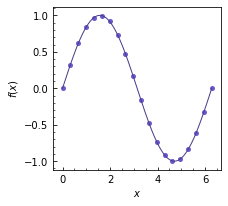

In [4]:
plot_line_points(xt, poly_int, xp=xtr, yp=ftr_int, points=True,
                 xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3)

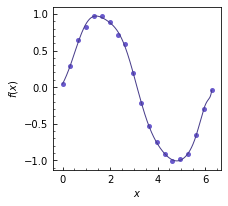

In [5]:
plot_line_points(xt, poly_fit, xp=xtr, yp=ftr_fit, points=True,
                 xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3)

## Task 1b

In [6]:
nkt = 1000
kt = np.linspace(k.min(), k.max(), nkt)

In [7]:
poly_int, a_int = poly_approx(lk, lPk, kt, method='regression', poly_order=np.size(kt))

LinAlgError: SVD did not converge in Linear Least Squares

In [8]:
print(a_int, np.size(a_int))

[ 0.00000000e+00  1.00000000e+00  2.10565825e-09 -1.66666676e-01
  2.45919224e-08  8.33329088e-03  5.18571209e-08 -1.98459424e-04
  3.18978048e-08  2.73895137e-06  6.86986162e-09 -2.72487001e-08
  5.47102044e-10  5.55130258e-11  1.52383075e-11 -2.36673694e-12
  1.11861168e-13 -1.14511490e-15 -5.06586598e-17  8.57852229e-19] 20


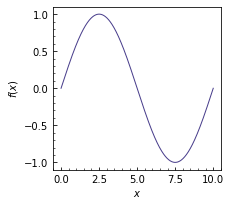

In [9]:
plot_line_points(kt, poly_int, xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3)

In [10]:
lkt = np.linspace(lk.min(), lk.max(), nkt)
poly_intl, a_intl = poly_approx(lk, lPk, lkt, method='interpolation')

In [11]:
poly_int, a_int = poly_approx(lk, lPk, lkt, method='regression', poly_order=20)

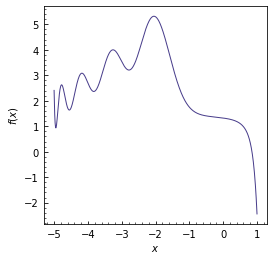

In [12]:
plot_line_points(lkt, poly_int, xlabel=r'$x$', ylabel=r'$f(x)$', figsize=4)

Do you get a sensible result? Think about what the routine is doing and try to come up with an explanation for the outcome of this exercise. (7 points)

Try regression with smaller poly_order values and find polynomial order for which at least somewhat sensible approximation can be obtained. What is that order? Think about a possible explanation for why this works for small order (3 points).

## Task 1c

In [13]:
def cubic_spline_coefficients(xi, fi):
    """
    compute coefficients of the interpolating natural cubic spline
    see Appendix in the note for the derivation and details of the algorithm
    
    Parameters: 
        xi, fi: numpy float vectors
                tabulated points and function values
            
    Returns:
        a, b, c, d: numpy float vectors
                cubic spline coefficients 
                dx = x - xi[i]
                fx = a[i] + dx*(b[i] + c[i]*dx + d[i]*dx*dx)

    """
    delx = np.diff(xi); delf = np.diff(fi)
    # form matrices to solve for spline coefficients
    vx = np.zeros_like(xi)
    # form rhs vector using python's array slicing 
    vx[1:-1:] = 3.*(delf[1::]/delx[1::] - delf[:-1:]/delx[:-1:])
    # construct 3 diagonals
    nx = np.size(xi)
    diags = np.zeros((3, nx))
    diags[1,0] = 1.; diags[1,-1] = 1.
    diags[1,1:-1:] = 2. * (delx[1::] + delx[:-1:])
    diags[0,1:] = delx[:]
    diags[2,1:-1] = delx[1:]
    # solve for coefficients c using Thomas algorithm for tri-diagonal matrices
    # see https://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)
    ac, bc, cc, dc = map(np.array, (diags[0,:], diags[1,:], diags[2,:], vx)) # copy arrays
    for k in range(1, nx):
        mk = ac[k] / bc[k-1]
        bc[k] = bc[k] - mk * cc[k-1] 
        dc[k] = dc[k] - mk * dc[k-1]
    
    c = np.zeros_like(bc)
    c[-1] = dc[-1] / bc[-1]

    for k in range(nx-2, -1, -1):
        c[k] = (dc[k]-cc[k]*c[k+1])/bc[k]

    # now get the rest of the coefficients
    b = delf[::]/delx[::] - (c[1::] + 2.*c[:-1:])*delx[::]/3.
    d = (c[1::] - c[:-1:])/(3.*delx[::]) 
    a = fi
    return a, b, c, d

In [32]:
def cubic_spline(xt, xi, a, b, c, d):
    """
    piecewise linear approximation of f(x) given input of tabulated values of xi and fi
    note that xi are expected in ascending order
    
    Returns:
        vector of spline values at test points x 

    """
    n = np.size(xi) - 1
    fxt = np.empty_like(xt)
    fpxt = np.empty_like(xt)
    fppxt = np.empty_like(xt)
    fpppxt = np.empty_like(xt)
    fintxt = np.empty_like(xt)
    for j, x in enumerate(xt):
        for i in range(n):
            if (x >= xi[i]) and (x <= xi[i+1]):
                dx = x - xi[i]
                fxt[j] = a[i] + dx*(b[i] + c[i]*dx + d[i]*dx*dx)
                fpxt[j] = b[i] + dx*(2*c[i] + 3*d[i]*dx)
                fppxt[j] = (2*c[i]) + (6*d[i]*dx)
                fpppxt[j] = 6*d[i]
                fintxt = (a[i]*dx) + (0.5*b[i]*dx*dx) + ((1/3)*c[i]*dx*dx*dx) + (0.25*d[i]*dx*dx*dx*dx)
        
    return fxt, fpxt, fppxt, fpppxt, fintxt

In [33]:
xt = np.linspace(np.pi, 3*np.pi,10)
xtest = np.linspace(np.pi, 3*np.pi, 100)
sinxt = np.sin(xt)

In [34]:
a, b, c, d = cubic_spline_coefficients(xt, sinxt)
spline_int, sinxp, sinxpp, sinxppp, sinxint = cubic_spline(xtest, xt, a, b, c, d)

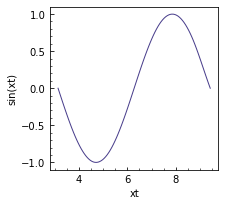

In [35]:
plot_line_points(xtest, spline_int, 
                 xlabel=r'xt', ylabel=r'sin(xt)', figsize=3)

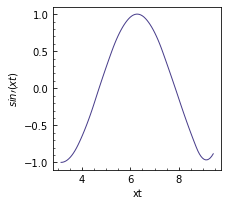

In [36]:
plot_line_points(xtest, sinxp, 
                 xlabel=r'xt', ylabel=r'$sin\prime(xt)$', figsize=3)

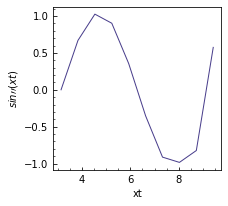

In [37]:
plot_line_points(xtest, sinxpp, 
                 xlabel=r'xt', ylabel=r'$sin\prime\prime(xt)$', figsize=3)

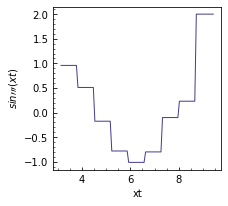

In [38]:
plot_line_points(xtest, sinxppp, 
                 xlabel=r'xt', ylabel=r'$sin\prime\prime\prime(xt)$', figsize=3)

In [39]:
sinxint

0.22789875112773442

## Task 1d

## Task 1e

## Task 1f

## Task 2a